# CMPE 462 - Project 3
## Logistic Matrix Factorization

**Student IDs: 2013400069, 2013400198, 2013400213**

## Problem Description

Binary matrices (Matrices with elements of 0/1) appear in many applications. A binary matrix can represent relations such as 'User $i$ bought item $j$', or 'Member $i$ likes Member $j$'. Such datasets are often sparse -- only a fraction of the possible entries of a matrix are known. 

A binary matrix can also viewed as the adjacency matrix of a bipartite graph. Hence each entry corresponds to an edge.
One task here is known as link prediction, meaning guessing the presence or absence of edges in the underlying graph. 
This prediction can then be used for several tasks such as recommendation or knowledge-base completion.

In this project, you are going to implement a matrix factorization with missing elements using Stochastic Gradient Descent (SGD), Batch SGD and GD first in numpy, then also making use of PyTorch. You will also analyze the effect of the fraction of missing elements, estimation rank and max iteration. 

The matrix you will factorize is a binary(logistic) matrix and has a specific pattern. Its elements that whose indices sum up to an even number are 1 and 0 otherwise. For more detailed derivation and problem description, you can analyze [this](https://github.com/atcemgil/notes/blob/master/Logistic%20Matrix%20Factorization.ipynb) notebook.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import torch
from torch.autograd import Variable
from torch import nn

In [66]:
def sigmoid(t):
    return 1./(1+np.exp(-t))

# Dataset Generation

This cell generates the dataset as we have discussed. It sets the elements whom indices sum up to even number to 1.

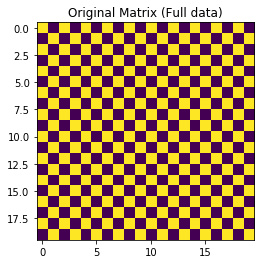

In [67]:
M = 20 # Use a square matrix of 50x50. You can change it if you wish
original_matrix = np.array([[int((i + j) % 2 == 0) for j in range(M)] for  i in range(M)])
#original_matrix = np.random.rand(M, M)
plt.imshow(original_matrix, interpolation='nearest')  
plt.title('Original Matrix (Full data)')
plt.show()

# Masking

Now mask the dataset. Number of elements to mask is set by a parameter. 

Seed the random for repeatability

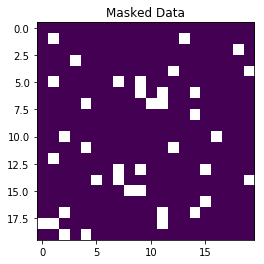

In [68]:
random.seed(10)
def generate_mask(M = 50, mask_count=M*M//10):
    masks = [(random.randint(0,M-1), random.randint(0,M-1)) for i in range(mask_count)]
    mask = np.ones((M,M))
    for m in masks:
        mask[m] = np.nan
    return mask

mask = generate_mask(M)
plt.imshow(mask, interpolation='nearest')  
plt.title('Masked Data')
plt.show()

# Gradient Descents

Implement **SGD**. **BGD** and **GD** in this cell using **numpy**. Compute the error of the resulting matrix compared to original data for approximation ranks in [1,M]. For measuring the quality of the fit, you should use the log-likelihood

\begin{eqnarray}
\log p(Y |W, H ) &=& \sum_j \sum_{i} M(i,j) Y(i,j) \left(\sum_k W(i,k) H(k,j)\right)  - \sum_j \sum_{i} M(i,j) \log\left( 1+ \exp\left(\sum_k W(i,k) H(k,j)\right)\right) 
\end{eqnarray}

For plot generation, use results computed by SGD.

In [69]:
def log_likelihood(M,Y,W,H):
    left_term = np.sum((M*Y)*(W.dot(H)))
    right_term= np.sum(M*np.log(1+np.exp(W.dot(H))))
    return left_term - right_term

In [187]:
# Implement SGD here. Add the method signatures for other gradient descents as well. 
# You can add a batch size parameter to merge
# all types of gradient descents into one method.
def sgd(original_matrix, mask, estimation_rank, MAX_ITER=10000, 
        eta=0.005, nu=0.5, batch_size=1):
    
    matrix_size = original_matrix.size
    if batch_size > matrix_size:
        raise ValueError("Please enter a value in range [1,size(original_matrix)]")
    
    W = np.random.randn(original_matrix.shape[0], estimation_rank)
    H = np.random.randn(estimation_rank, original_matrix.shape[1])
    
    mask[np.isnan(mask)] = 0
    errors = []
    

    for _ in range(MAX_ITER):
        errors.append(log_likelihood(mask,original_matrix,W,H))

        cells = np.arange(matrix_size)
        np.random.shuffle(cells)
        cells = cells[:batch_size]

        i = cells//original_matrix.shape[1]
        j = cells%original_matrix.shape[1]

        mask_bgd = np.zeros(original_matrix.shape)
        mask_bgd[i,j] = 1

        mask_W = np.zeros(W.shape)
        mask_W[i,:] = 1
        mask_H = np.zeros(H.shape)
        mask_H[:,j] = 1
        dH = W.T.dot(mask*mask_bgd*(original_matrix-sigmoid(W.dot(H)))) - nu*mask_H*H
        dW = (mask*mask_bgd*(original_matrix-sigmoid(W.dot(H)))).dot(H.T) - nu*mask_W*W

        H = H + eta*dH
        W = W + eta*dW
        
    return (W,H,errors)


# Number of iterations
MAX_ITER = 10000

# Compute error for varying estimation ranks from 1 to M
errors = [] # store the error to this list.
final_W, final_H, errors = sgd(original_matrix, mask, 1, 
                               MAX_ITER=MAX_ITER,nu=0,batch_size=10)

Plot error vs estimation rank.

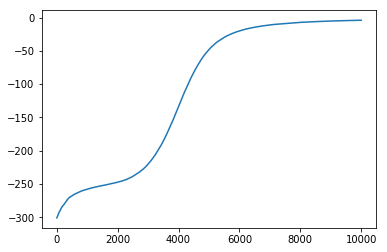

In [181]:
error
plt.plot(range(0,len(errors)), errors)
plt.show()

Now compute error for both changing rank( 1 to M) and max_iter(5000-20000). Plot it as a heatmap. You can use the plotting code below.

In [120]:
# Run sgd code once for 20000 iterations filter the errors between 5000 and 20000

MAX_ITER = 20000
changing_rank = np.arange(M) + 1
batch_size = 1

errors = [sgd(original_matrix, mask, rank, MAX_ITER=MAX_ITER, batch_size=batch_size)[-1] for rank in changing_rank]

In [121]:
errors = np.array(errors)
errors = errors[:,5000:]

In [122]:
errors.shape

(20, 20000)

In [123]:
errors[:,-1]

array([-256.08891102, -248.14736092, -153.91939427, -119.08888464,
        -85.08043468,  -79.25247237,  -52.51986008,  -68.75368959,
        -57.98514096,  -58.88514392,  -84.48409069,  -54.30807182,
        -20.39240548,  -30.03791183,  -47.55715111,  -54.66669524,
        -43.0337075 ,  -39.8853157 ,  -42.39833817,  -20.71683022])

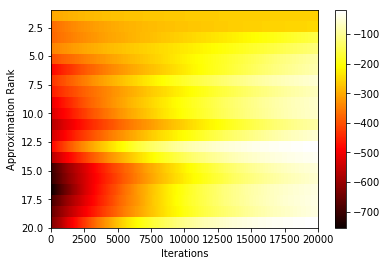

In [124]:
plt.imshow(errors, cmap='hot', interpolation='nearest', extent=[5000,20000,M,1], aspect='auto')
plt.xlabel('Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

In [147]:
# Run the sgd code for 5000, 6500, ..., 20000 iterations separately and plot heatmap

MAX_ITER = np.arange(5000,20001,1500)
changing_rank = np.arange(M) + 1
batch_size = 1

errors = [[sgd(original_matrix, mask, rank, MAX_ITER=_iter, batch_size=batch_size)[-1][-1] for _iter in MAX_ITER] for rank in changing_rank]

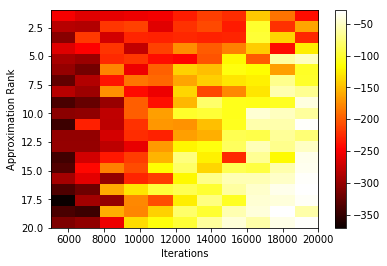

In [149]:
plt.imshow(errors, cmap='hot', interpolation='nearest', extent=[5000,20000,M,1], aspect='auto')
plt.xlabel('Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

### Now analyze the effect of varying the hidden element count(set your own limits) and approximation rank

In [134]:
MAX_ITER = 20000
changing_rank = np.arange(M) + 1
batch_size = 1

changing_mask = (M*M)*np.linspace(0.1, 1.0, num=9, endpoint=False)
changing_mask = changing_mask.astype(int)
print(changing_mask/(M*M))

#first [-1] gets error list from returning tuple, second [-1] gets last element of this list
errors = [[sgd(original_matrix, generate_mask(M,mask_filter), rank, MAX_ITER=MAX_ITER, 
               batch_size=batch_size)[-1][-1] for mask_filter in changing_mask] for rank in changing_rank]

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


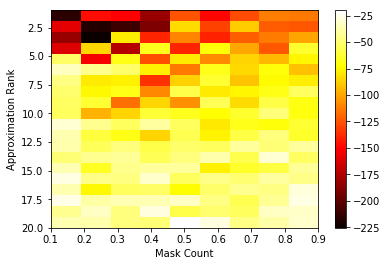

In [136]:
plt.imshow(errors, cmap='hot', interpolation='nearest', 
           extent=[changing_mask[0]/(M*M), changing_mask[-1]/(M*M),
                   changing_rank[-1], changing_rank[0]], aspect='auto')
plt.xlabel('Mask Count')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

# PyTorch

Now implement BGD and SGD using PyTorch and generate the same plots.

In [192]:
import torch
from torch.autograd import Variable

In [193]:
def torch_log_loss(M,Y,W,H):
    left_term = torch.sum(torch.mul(torch.mul(M,Y), torch.mm(W,H)))
    right_term = torch.sum(torch.mul(M, torch.log(1+torch.exp(torch.mm(W,H)))))
    return left_term - right_term

In [199]:
def torch_gd(original_matrix, mask, estimation_rank, MAX_ITER, batch_size, eta=0.005, nu=0.01):
    matrix_size = original_matrix.size

    # input
    Y = Variable(torch.Tensor(original_matrix), requires_grad=False)

    # outputs
    W = np.random.randn(original_matrix.shape[0], estimation_rank)
    H = np.random.randn(estimation_rank, original_matrix.shape[1])

    W = Variable(torch.Tensor(W), requires_grad=True)
    H = Variable(torch.Tensor(H), requires_grad=True)

    mask[np.isnan(mask)] = 0
    Mask = Variable(torch.Tensor(mask), requires_grad=False)
    
    errors = []
    for epoch in range(MAX_ITER):
        E = torch_log_loss(Mask,Y,W,H)
        errors.append(float(E))
        
        cells = np.arange(matrix_size)
        np.random.shuffle(cells)
        cells = cells[:batch_size]
        
        i = cells//original_matrix.shape[1]
        j = cells%original_matrix.shape[1]
        
        mask_bgd = np.zeros(original_matrix.shape)
        mask_bgd[i,j] = 1
        Mask_bgd = Variable(torch.Tensor(mask_bgd), requires_grad=False)
        
        E = torch_log_loss(torch.mul(Mask,Mask_bgd),Y,W,H)
        E.backward()
        
        mask_W = np.zeros(W.shape)
        mask_W[i,:] = 1
        mask_W = Variable(torch.Tensor(mask_W), requires_grad=False)
        
        mask_H = np.zeros(H.shape)
        mask_H[:,j] = 1
        mask_H = Variable(torch.Tensor(mask_H), requires_grad=False)
        
        W.data.add_(eta * (W.grad.data + nu*torch.mul(mask_W,W)))
        H.data.add_(eta * (H.grad.data + nu*torch.mul(mask_H,H)))

        W.grad.zero_()
        H.grad.zero_()
        
    return (W,H,errors)

In [201]:
_, _, errors = torch_gd(original_matrix, mask, 1, MAX_ITER=10000,batch_size=10, nu=0.05)
errors = np.array(errors)
errors[np.isnan(errors)] = 0

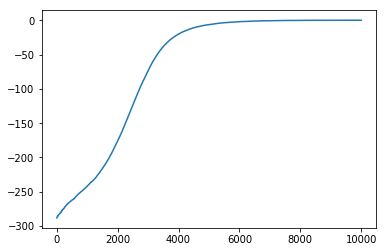

In [202]:
plt.plot(range(0,len(errors)), errors)
plt.show()

In [203]:
MAX_ITER = 20000
changing_rank = np.arange(M) + 1
batch_size = 1

errors = [torch_gd(original_matrix, mask, rank, MAX_ITER=MAX_ITER, batch_size=batch_size)[-1] for rank in changing_rank]
errors = np.array(errors)
errors = errors[:,5000:]

In [212]:
errors[0]

array([-267.11813354, -267.11434937, -267.11450195, ..., -237.54844666,
       -237.52502441, -237.52867126])

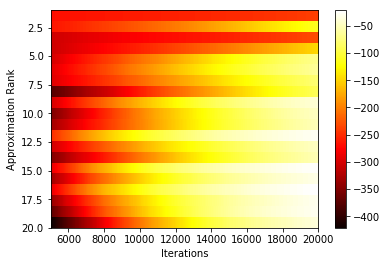

In [210]:
plt.imshow(errors, cmap='hot', interpolation='nearest', extent=[5000,5000+errors.shape[1],M,1], aspect='auto')
plt.xlabel('Iterations')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()

In [213]:
MAX_ITER = 20000
changing_rank = np.arange(M) + 1
batch_size = 1

changing_mask = (M*M)*np.linspace(0.1, 1.0, num=9, endpoint=False)
changing_mask = changing_mask.astype(int)
print(changing_mask/(M*M))

#first [-1] gets error list from returning tuple, second [-1] gets last element of this list
errors = [[torch_gd(original_matrix, generate_mask(M,mask_filter), rank, MAX_ITER=MAX_ITER, 
               batch_size=batch_size)[-1][-1] for mask_filter in changing_mask] for rank in changing_rank]

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


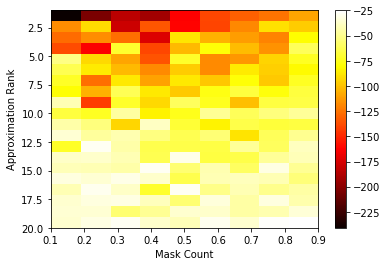

In [214]:
plt.imshow(errors, cmap='hot', interpolation='nearest', 
           extent=[changing_mask[0]/(M*M), changing_mask[-1]/(M*M),
                   changing_rank[-1], changing_rank[0]], aspect='auto')
plt.xlabel('Mask Count')
plt.ylabel('Approximation Rank')
plt.colorbar()
plt.show()